In [1]:
import importlib
import torch
import torch.nn as nn
import itertools
from collections import OrderedDict 
import onnx
import tvm
from onnx import shape_inference

import op_constraint as opc
import op_projection as opp
import random_graph as rg
import utility
import graph_debug as gd

In [13]:
importlib.reload(rg)  #Reload a previously imported module
importlib.reload(opc)
importlib.reload(opp)
importlib.reload(utility)
importlib.reload(gd)

<module 'graph_debug' from '/home/newuser/ruochen_workspace/TVMGraphFuzzer/Fuzzer/graph_generator/graph_debug.py'>

In [2]:
graph_gen_parameter = {
    "node_num":4, 
    "graph_mode":"ER", 
    "p":0.3
}

In [3]:
input_shapes = [[1, 3, 224, 224], [1, 6, 112, 112], [1, 12, 56, 56], [1, 24, 28, 28]]
output_shapes = [[1, 6, 112, 112], [1, 12, 56, 56], [1, 24, 28, 28], [1, 36, 14, 14]]
#subgraph1's input shape=input_shapes[0], output shape=output_shapes[0]
#subgraph2's input shape=input_shapes[1]=subgraph1's output shape,   output shape=output_shapes[1]
input_shapes = input_shapes[:3]
output_shapes = output_shapes[:3]
#Class recorder can append subgraph, record opt seq, clear subgraph, save and load
recorder = rg.recorder("saved_graph", "saved_graph")
test_subgraphs = list()
for idx in range(len(input_shapes)):   #0,1,2,3
    input_shape = input_shapes[idx]
    output_shape = output_shapes[idx]
    test_subgraph1 = rg.get_sub_graph(input_shape, output_shape, recorder=recorder, 
                                      node_num=graph_gen_parameter["node_num"], 
                                      graph_mode=graph_gen_parameter["graph_mode"], p=graph_gen_parameter["p"])
    test_subgraph1 = test_subgraph1.eval()  #evaluation mode. 
    test_subgraphs.append(test_subgraph1) 

combined_model = torch.nn.Sequential(*test_subgraphs)
combined_model = combined_model.eval()
assert combined_model(torch.randn(input_shapes[0])).shape == tuple(output_shapes[-1])

In [4]:
random_input = torch.randn(input_shapes[0])
combined_model(random_input)

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  6.4882e-01,  8.9392e-01,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  3.0440e-01,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          ...,
          [ 0.0000e+00,  2.9942e+00,  9.8942e-01,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  1.8599e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 4.8786e-05, -1.8009e-01, -2.3328e+00,  ..., -5.0482e-01,
           -4.5785e-01, -2.2218e-01]],

         [[ 4.8457e-01,  1.3256e+00,  0.0000e+00,  ...,  2.6411e-01,
            3.7329e-02,  1.9476e-01],
          [ 0.0000e+00,  2.0845e+00,  0.0000e+00,  ...,  2.4462e-01,
            1.7537e-01,  4.5770e-01],
          [ 0.0000e+00,  6.7113e-01,  0.0000e+00,  ...,  1.9106e-01,
            3.1555e-01,  1.0408e-01],
          ...,
     

In [5]:
random_input = torch.randn(input_shapes[0])
result = gd.test_under_pytorch(combined_model, random_input)

/home/malei/.local/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.


In [29]:
combined_model

Sequential(
  (0): TestSubgraph(
    (input_cell): Conv2d(3, 6, kernel_size=(5, 2), stride=(2, 2), padding=(2, 0), bias=False)
    (normal_cell_list): ModuleList(
      (0): Cell(
        (subnode_list): ModuleList(
          (0): ReLU()
          (1): Sequential(
            (Conv): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), groups=6)
            (pointwiseConv): Conv2d(6, 6, kernel_size=(1, 1), stride=(1, 1))
          )
          (2): GroupNorm(6, 6, eps=0.1, affine=True)
        )
      )
      (1): Cell(
        (subnode_list): ModuleList(
          (0): ReLU()
          (1): Sequential(
            (Conv): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), groups=6)
            (pointwiseConv): Conv2d(6, 6, kernel_size=(1, 1), stride=(1, 1))
          )
          (2): GroupNorm(6, 6, eps=0.1, affine=True)
        )
      )
      (2): Cell(
        (subnode_list): ModuleList(
          (0): ReLU()
          (1): S

In [4]:
combined_model

Sequential(
  (0): TestSubgraph(
    (input_cell): Conv2d(3, 6, kernel_size=(4, 2), stride=(2, 2), padding=(1, 1), dilation=(1, 2), bias=False)
    (normal_cell_list): ModuleList(
      (0): Cell(
        (subnode_list): ModuleList(
          (0): Softmin(dim=3)
          (1): SplitWrapper()
          (2): Sequential(
            (Conv): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), groups=6)
            (pointwiseConv): Conv2d(6, 6, kernel_size=(1, 1), stride=(1, 1))
          )
          (3): Linear(in_features=112, out_features=112, bias=False)
          (4): Linear(in_features=112, out_features=112, bias=False)
          (5): Linear(in_features=112, out_features=112, bias=False)
          (6): GroupNorm(6, 6, eps=0.01, affine=True)
          (7): Dropout(p=0.5, inplace=False)
          (8): Dropout(p=0.4, inplace=False)
          (9): BatchNorm2d(6, eps=1e-05, momentum=0.5, affine=False, track_running_stats=True)
          (10): CatWrapper()
     

In [39]:
tvm.transform.PassContext.current().diag_ctx.diagnostics[0].message

'The Relay type checker is unable to show the following types match.\nIn particular dimension 0 conflicts: 24 does not match 7.'

In [10]:
mod, params = utility.torch2relay(combined_model, random_input)

DiagnosticError: Traceback (most recent call last):
  [bt] (8) 9   libtvm.dylib                        0x0000000132e039db void std::__1::__invoke_void_return_wrapper<void>::__call<void tvm::runtime::TypedPackedFunc<tvm::IRModule (tvm::IRModule, tvm::transform::PassContext)>::AssignTypedLambda<tvm::relay::transform::InferType()::$_1>(tvm::relay::transform::InferType()::$_1)::'lambda'(tvm::runtime::TVMArgs const&, tvm::runtime::TVMRetValue*)&, tvm::runtime::TVMArgs, tvm::runtime::TVMRetValue*>(tvm::relay::transform::InferType()::$_1&&...) + 91
  [bt] (7) 8   libtvm.dylib                        0x0000000132e03a8b decltype(std::__1::forward<tvm::relay::transform::InferType()::$_1>(fp)(std::__1::forward<void tvm::runtime::TypedPackedFunc<tvm::IRModule (tvm::IRModule, tvm::transform::PassContext)>::AssignTypedLambda<tvm::relay::transform::InferType()::$_1>(tvm::relay::transform::InferType()::$_1)::'lambda'(tvm::runtime::TVMArgs const&, tvm::runtime::TVMRetValue*)&>(fp0)...)) std::__1::__invoke<void tvm::runtime::TypedPackedFunc<tvm::IRModule (tvm::IRModule, tvm::transform::PassContext)>::AssignTypedLambda<tvm::relay::transform::InferType()::$_1>(tvm::relay::transform::InferType()::$_1)::'lambda'(tvm::runtime::TVMArgs const&, tvm::runtime::TVMRetValue*)&, tvm::runtime::TVMArgs, tvm::runtime::TVMRetValue*>(tvm::relay::transform::InferType()::$_1&&, void tvm::runtime::TypedPackedFunc<tvm::IRModule (tvm::IRModule, tvm::transform::PassContext)>::AssignTypedLambda<tvm::relay::transform::InferType()::$_1>(tvm::relay::transform::InferType()::$_1)::'lambda'(tvm::runtime::TVMArgs const&, tvm::runtime::TVMRetValue*)&...) + 91
  [bt] (6) 7   libtvm.dylib                        0x0000000132e04283 void tvm::runtime::TypedPackedFunc<tvm::IRModule (tvm::IRModule, tvm::transform::PassContext)>::AssignTypedLambda<tvm::relay::transform::InferType()::$_1>(tvm::relay::transform::InferType()::$_1)::'lambda'(tvm::runtime::TVMArgs const&, tvm::runtime::TVMRetValue*)::operator()(tvm::runtime::TVMArgs const&, tvm::runtime::TVMRetValue*) const + 1971
  [bt] (5) 6   libtvm.dylib                        0x0000000132e04920 tvm::relay::transform::InferType()::$_1::operator()(tvm::IRModule, tvm::transform::PassContext const&) const + 1456
  [bt] (4) 5   libtvm.dylib                        0x000000012fd57412 tvm::DiagnosticContext::Render() + 562
  [bt] (3) 4   libtvm.dylib                        0x000000012f586fb5 tvm::runtime::detail::LogFatal::~LogFatal() + 21
  [bt] (2) 3   libtvm.dylib                        0x000000012f589a91 tvm::runtime::detail::LogFatal::~LogFatal() + 49
  [bt] (1) 2   libtvm.dylib                        0x000000012f589b4d tvm::runtime::detail::LogFatal::Entry::Finalize() + 173
  [bt] (0) 1   libtvm.dylib                        0x000000013380a71a tvm::runtime::Backtrace() + 58
  File "/Users/yuhenghuang/work/AI_stack/tvm/src/ir/diagnostic.cc", line 105
DiagnosticError: one or more error diagnostics were emitted, please check diagnostic render for output.

In [9]:
combined_model(torch.randn(input_shapes[0]))

tensor([[[[ 1.7807e+01,  2.6822e+01,  1.4889e+01,  ...,  4.8685e-02,
            5.8264e-02,  1.2312e-01],
          [ 1.7860e+01,  2.7068e+01,  1.5308e+01,  ..., -1.2939e-01,
           -7.2229e-02,  2.7789e-02],
          [ 1.7624e+01,  2.7241e+01,  1.5722e+01,  ..., -1.5294e-01,
           -1.1742e-01,  2.4544e-03],
          ...,
          [ 1.6009e+01,  2.9613e+01,  2.0090e+01,  ...,  2.0855e-01,
            1.1039e-01, -1.5762e-02],
          [ 1.6075e+01,  2.9756e+01,  2.0263e+01,  ...,  2.0360e-01,
            1.3420e-01,  2.4672e-02],
          [ 1.6459e+01,  2.8648e+01,  1.8582e+01,  ...,  6.7051e-02,
            1.2440e-01,  1.0360e-01]],

         [[ 1.6086e+01,  3.0104e+01,  2.1149e+01,  ...,  8.3456e-03,
            3.1168e-02,  8.8645e-02],
          [ 1.6177e+01,  2.9356e+01,  2.0202e+01,  ..., -1.1458e-02,
            3.0884e-02,  1.1095e-01],
          [ 1.6409e+01,  2.9099e+01,  1.9637e+01,  ...,  7.4207e-03,
            5.1711e-02,  8.5891e-02],
          ...,
     

In [91]:
graph_gen_parameter = {
    "node_num":6, 
    "graph_mode":"ER", 
    "p":0.6
}

In [92]:
sub_graph = rg.RandomGraph(**graph_gen_parameter)

In [93]:
graph = sub_graph.generate_graph()

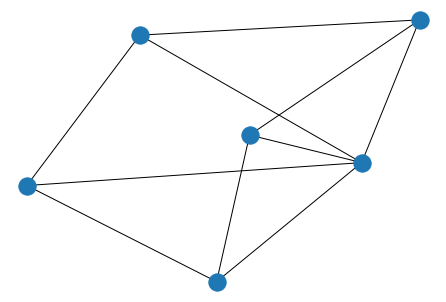

In [94]:
nx.draw(sub_graph.graph)